In [ ]:
%load_ext autoreload
%autoreload 2
import os
import re
import os
from configs import project_config
import matplotlib.pyplot as plt
import numpy as np
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.Markovian_fSinLog.recursive_Markovian_PostMeanScore_fSinLog_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_LowFTh_T256_H05_tl_110data_StbleTgt import get_config

In [ ]:
config = get_config()
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
assert config.deltaT == 1./256
num_paths = 1024 if config.feat_thresh == 1. else 10240

In [ ]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape == y_pred.shape and len(y_pred.shape) == 1)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return (np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [ ]:
if "fQuadSin" in config.data_path:
    minx = -1.5
    assert config.sin_space_scale == 25.
    ts_type = "fQuadSin2"
    include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(
        ".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/QuadSinHF2/"
elif "fSinLog" in config.data_path:
    minx = -1.5
    ts_type = "fSinLog"
    include = (f"{config.deltaT:.3e}dT_{config.log_space_scale}b_{config.sin_space_scale}c").replace(
        ".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/SinLog/"
elif "fBiPot" in config.data_path:
    minx = -1.5
    ts_type = "fBiPot"
    include = (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c").replace(
        ".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/BiPot/"

maxx = -minx
print(ts_type)

In [ ]:
keepfiles = []
for file in os.listdir(root_nadaraya_dir):
    if "IIDNadaraya" in file and ts_type[:-1] in file and include in file and "DriftEvalExp" in file:
        keepfiles.append(root_nadaraya_dir+file)
print(len(keepfiles), ts_type)
assert len(keepfiles)>0, "No files found"
def extract_bw_number(s):
    match = s.split("/")[-1].split("_")[3][:-2]
    return float("0." + match)


keepfiles = sorted(keepfiles, key=extract_bw_number)
bws = [extract_bw_number(f) for f in keepfiles]
Xshape = np.load(keepfiles[0]).shape[0]
print(keepfiles)

In [ ]:
vispaths = np.linspace(minx, maxx, Xshape)
if "QuadSin" in config.data_path:
    print(config.quad_coeff, config.sin_coeff, config.sin_space_scale, config.deltaT)
    is_true_drift = -2.*config.quad_coeff * vispaths.flatten() + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*vispaths.flatten())
    label = "$\mu_{2}$"
    dirname = "QuadSinHF2"
elif "BiPot" in config.data_path:
    is_true_drift = -(4.*config.quartic_coeff * np.power(vispaths, 3) + 2.*config.quad_coeff * vispaths + config.const).flatten()
    label = "$\mu_{3}$"
    dirname = "BiPot"
elif "SinLog" in config.data_path:
    is_true_drift = (-np.sin(config.sin_space_scale*vispaths)*np.log(1+config.log_space_scale*np.abs(vispaths))/config.sin_space_scale).flatten()
    label = "$\mu_{1}$"
    dirname = "SinLog"
print(ts_type)

In [ ]:
curr_mse = np.inf
toSave = True
for f_idx in range(len(keepfiles)):
    if f_idx <25: continue
    bw = bws[f_idx]
    f = keepfiles[f_idx]
    try:
        muhats = np.load(f)
        is_drift = muhats.mean(axis=-1).flatten()
        mse = (rmse_ignore_nans(is_true_drift, is_drift))
        if mse < curr_mse:
            curr_mse = mse
            fig, ax = plt.subplots(figsize=(14,9))
            plt.scatter(vispaths, is_true_drift,label="True Drift", color="red")
            mu_hats_minq = np.quantile(muhats, axis=-1, q=0.005) # Lower bound
            mu_hats_maxq = np.quantile(muhats, axis=-1, q=0.995) # Upper bound
            print(ymax)
            ymin = is_drift - mu_hats_minq
            ymax = mu_hats_maxq - is_drift
            ymin[ymin < 0.] = 0.
            ymax[ymax < 0.] = 0.
            plt.errorbar(vispaths, is_drift, yerr=[ymin, ymax], xerr=None, fmt='o', color="blue", alpha=0.4)
            plt.scatter(vispaths, is_drift, label="Estimated Drift", color="blue")
            plt.legend(fontsize=18)
            plt.title(rf"Nadaraya Estimator for {label}", fontsize=40)
            plt.grid(True)
            ax.tick_params(labelsize=38)
            plt.ylabel("Drift Value", fontsize=48)
            plt.xlabel(r"State $Y$", fontsize=48)
            plt.legend(fontsize=24)
            plt.tight_layout()
            if toSave:
                plt.savefig(root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/{dirname}/IIDNadaraya_{ts_type}_DriftEvalExp_{round(bw, 6)}bw".replace(".","")+".png",  bbox_inches='tight')
            plt.show()
            plt.close()
            print(f_idx, bw, curr_mse)
    except ValueError as e:
        plt.close()
        continue


In [ ]:
np.load(f).shape

In [ ]:
def get_drifttrack_files(root_nadaraya_dir, ts_type, num_paths):
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    true_files = []
    local_files = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file:
            if "QuadSin" in ts_type:
                if "DriftTrack" in file and ts_type[:-1] in file and include in file and f"{config.sin_space_scale}c".replace(".", "") in file:
                    if "true" in file:
                        true_files.append(root_nadaraya_dir+file)
                    elif "global" in file:
                        local_files.append(root_nadaraya_dir+file)
            else:
                if "DriftTrack" in file and ts_type[:-1] in file and include in file:
                    if "true" in file:
                        true_files.append(root_nadaraya_dir+file)
                    elif "global" in file:
                        local_files.append(root_nadaraya_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    bws_local = [extract_bw_number(f) for f in local_files]
    assert np.all(bws==bws_local)
    return true_files, local_files, bws

In [ ]:
true_files, local_files, bws = get_drifttrack_files(root_nadaraya_dir=root_nadaraya_dir, ts_type=ts_type, num_paths=num_paths)
local_files, len(bws)

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_3786/3201106454.py:13: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_3786/3201106454.py:14: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


0.04757127444139812 2.82e-05 inf
0.03811068447073045 3.72e-05 inf


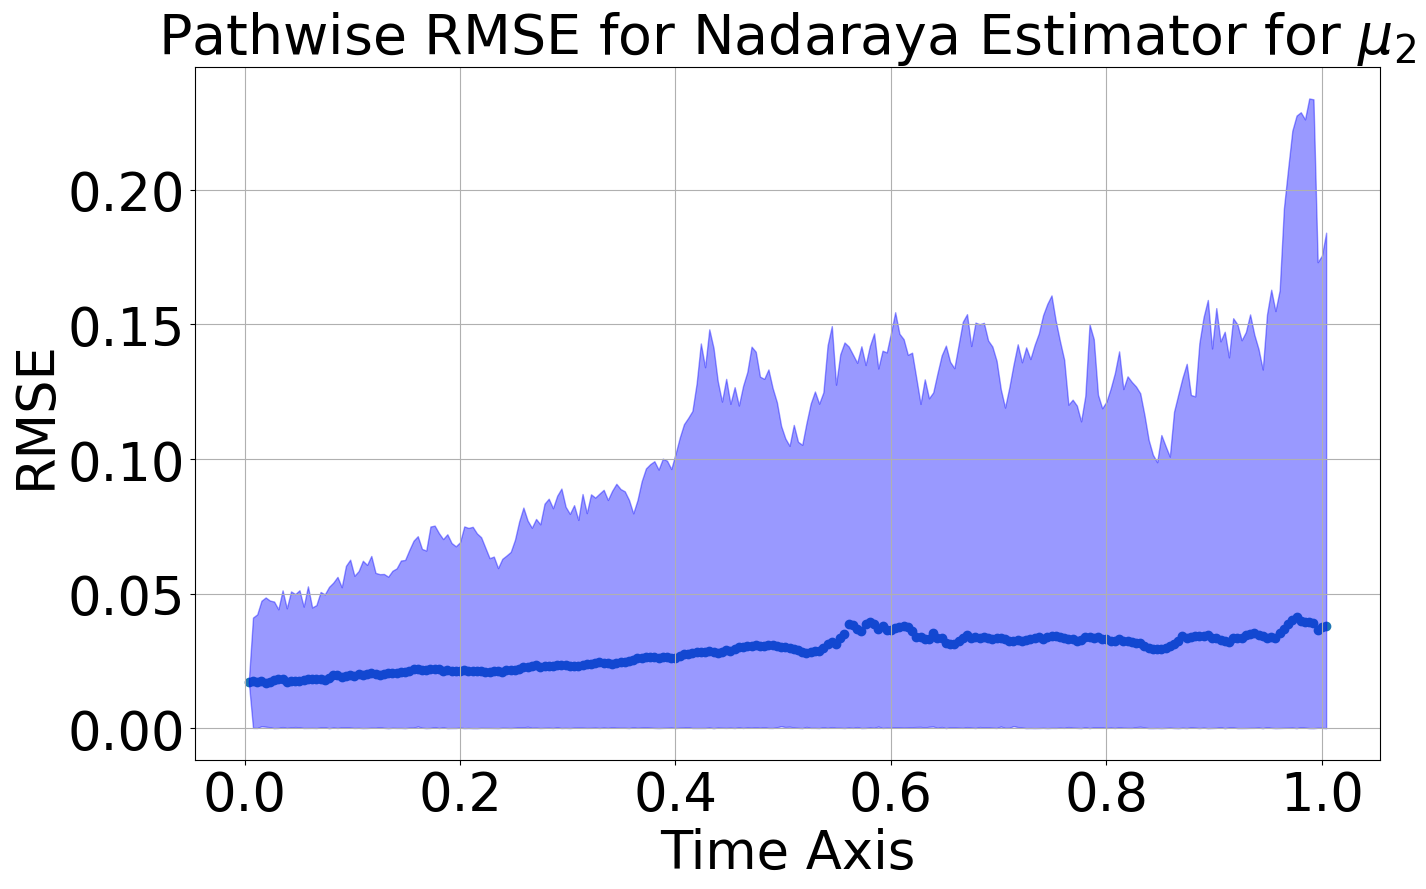

Final time cumulative MSE local-time error 0.03811068447073045 at bw 3.72e-05

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/QuadSinHF2/IIDNadaraya_fQuadSinHF_DriftTrack_0000372bw_10240NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_global_states.npy
0.045720088395317736 4.91e-05 0.03811068447073045
0.03645489032700068 6.49e-05 0.03811068447073045


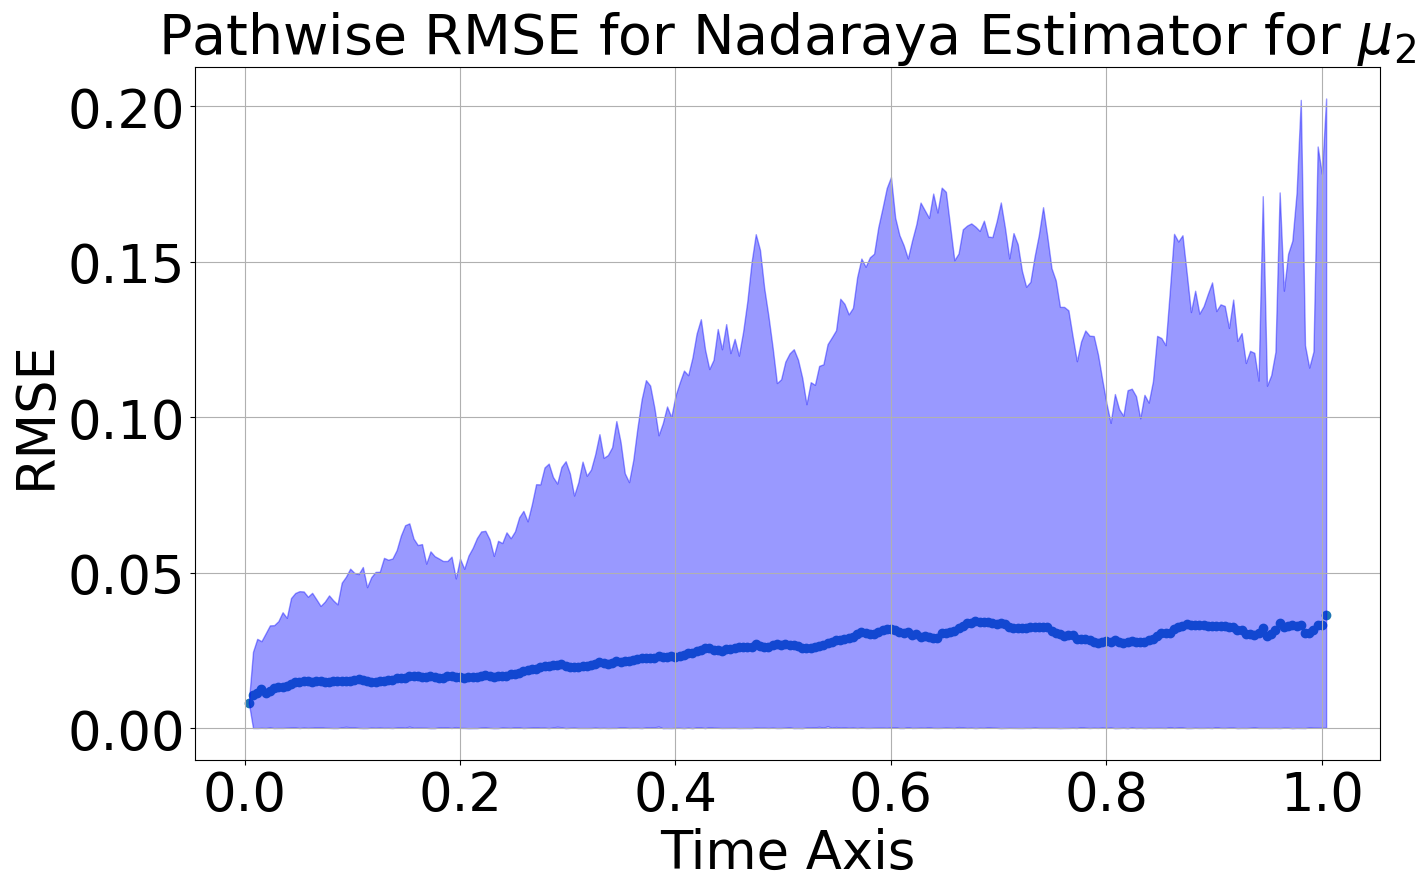

Final time cumulative MSE local-time error 0.03645489032700068 at bw 6.49e-05

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/QuadSinHF2/IIDNadaraya_fQuadSinHF_DriftTrack_0000649bw_10240NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_global_states.npy
0.03110107756084992 8.57e-05 0.03645489032700068


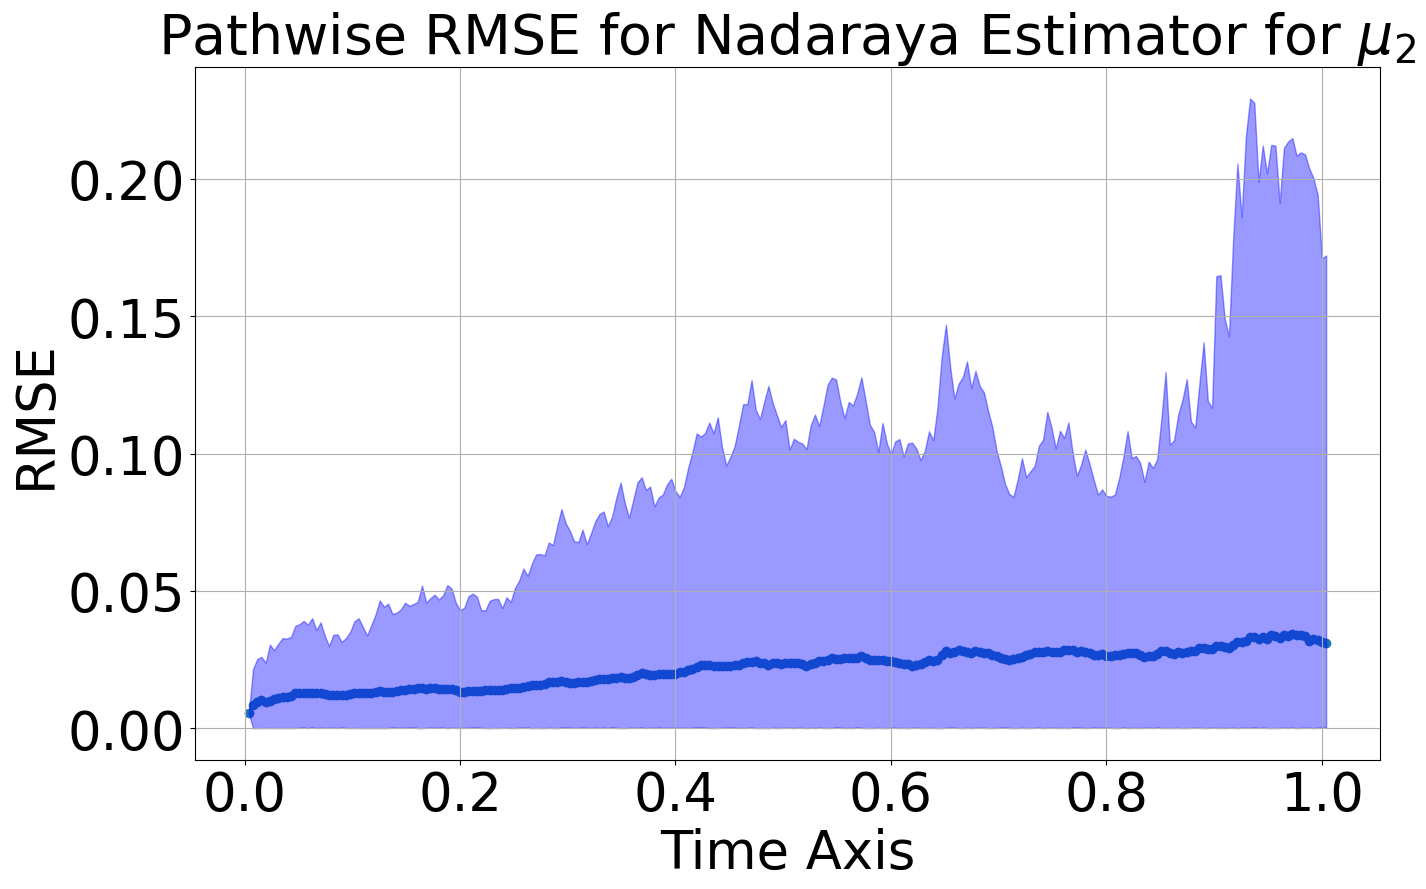

Final time cumulative MSE local-time error 0.03110107756084992 at bw 8.57e-05

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/QuadSinHF2/IIDNadaraya_fQuadSinHF_DriftTrack_0000857bw_10240NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_global_states.npy
0.024718657459166366 0.0001131 0.03110107756084992


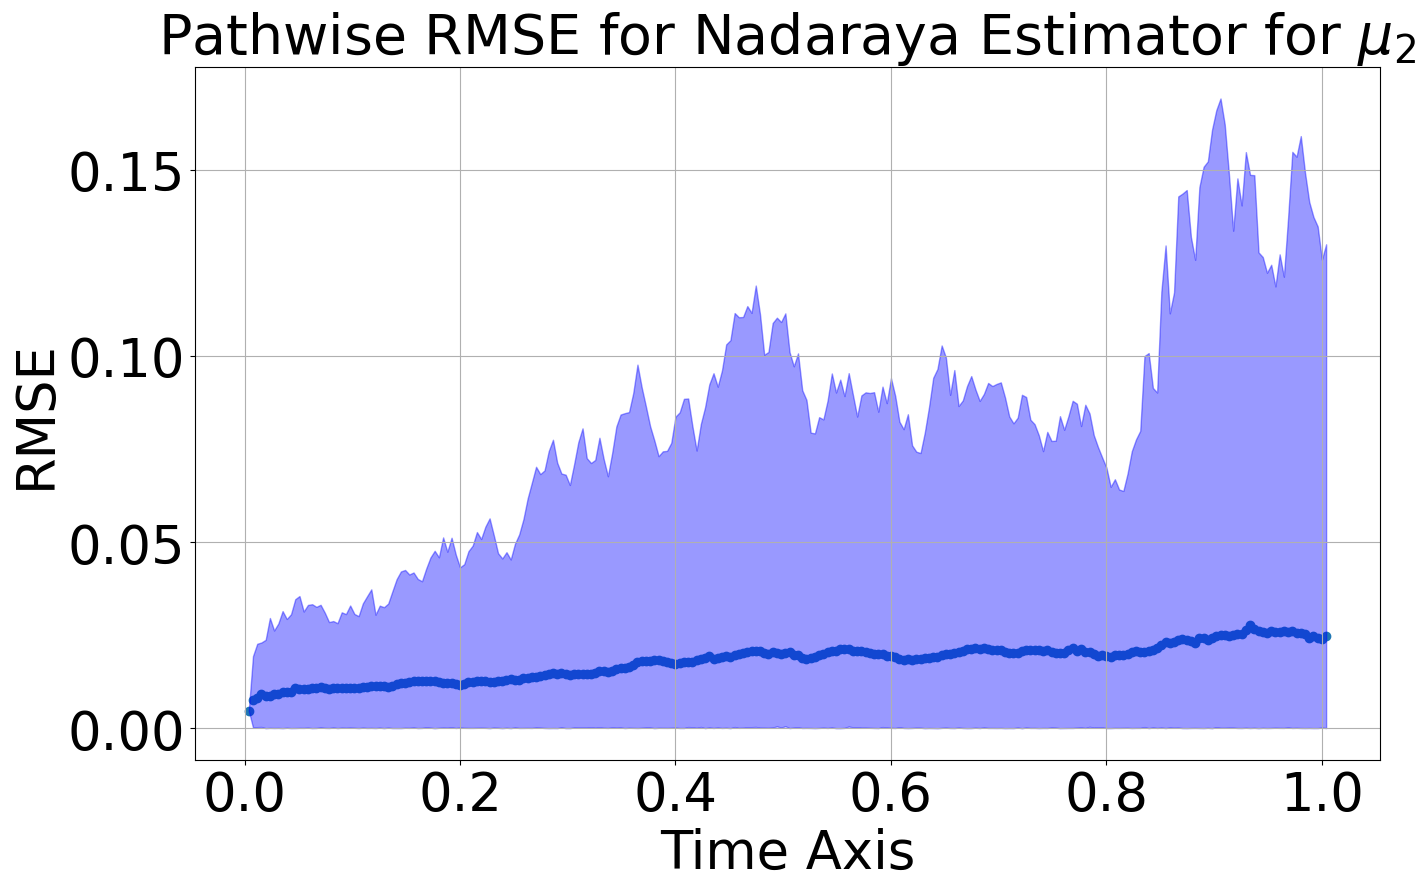

Final time cumulative MSE local-time error 0.024718657459166366 at bw 0.0001131

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/QuadSinHF2/IIDNadaraya_fQuadSinHF_DriftTrack_0001131bw_10240NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_global_states.npy
0.026066474251817674 0.0001493 0.024718657459166366
0.026701671125923792 0.0001972 0.024718657459166366
0.02143759320159753 0.0002603 0.024718657459166366


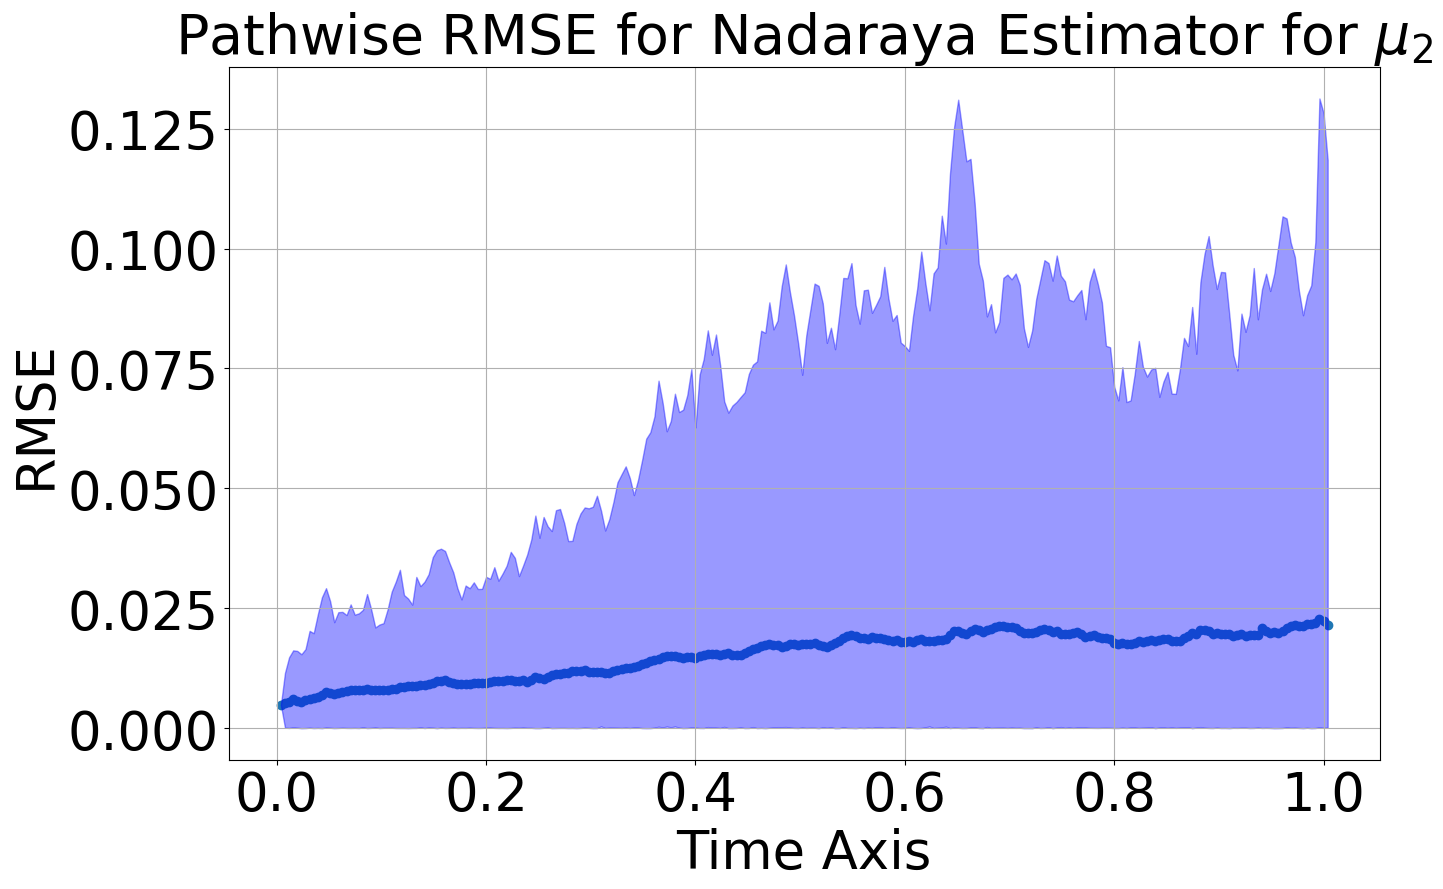

Final time cumulative MSE local-time error 0.02143759320159753 at bw 0.0002603

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/QuadSinHF2/IIDNadaraya_fQuadSinHF_DriftTrack_0002603bw_10240NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_global_states.npy
0.02448927109631399 0.0003437 0.02143759320159753
0.02162757340984904 0.0004538 0.02143759320159753
0.02308125438518041 0.0005992 0.02143759320159753
0.022197798733748622 0.0007912 0.02143759320159753
0.01801021382829965 0.0013793 0.02143759320159753


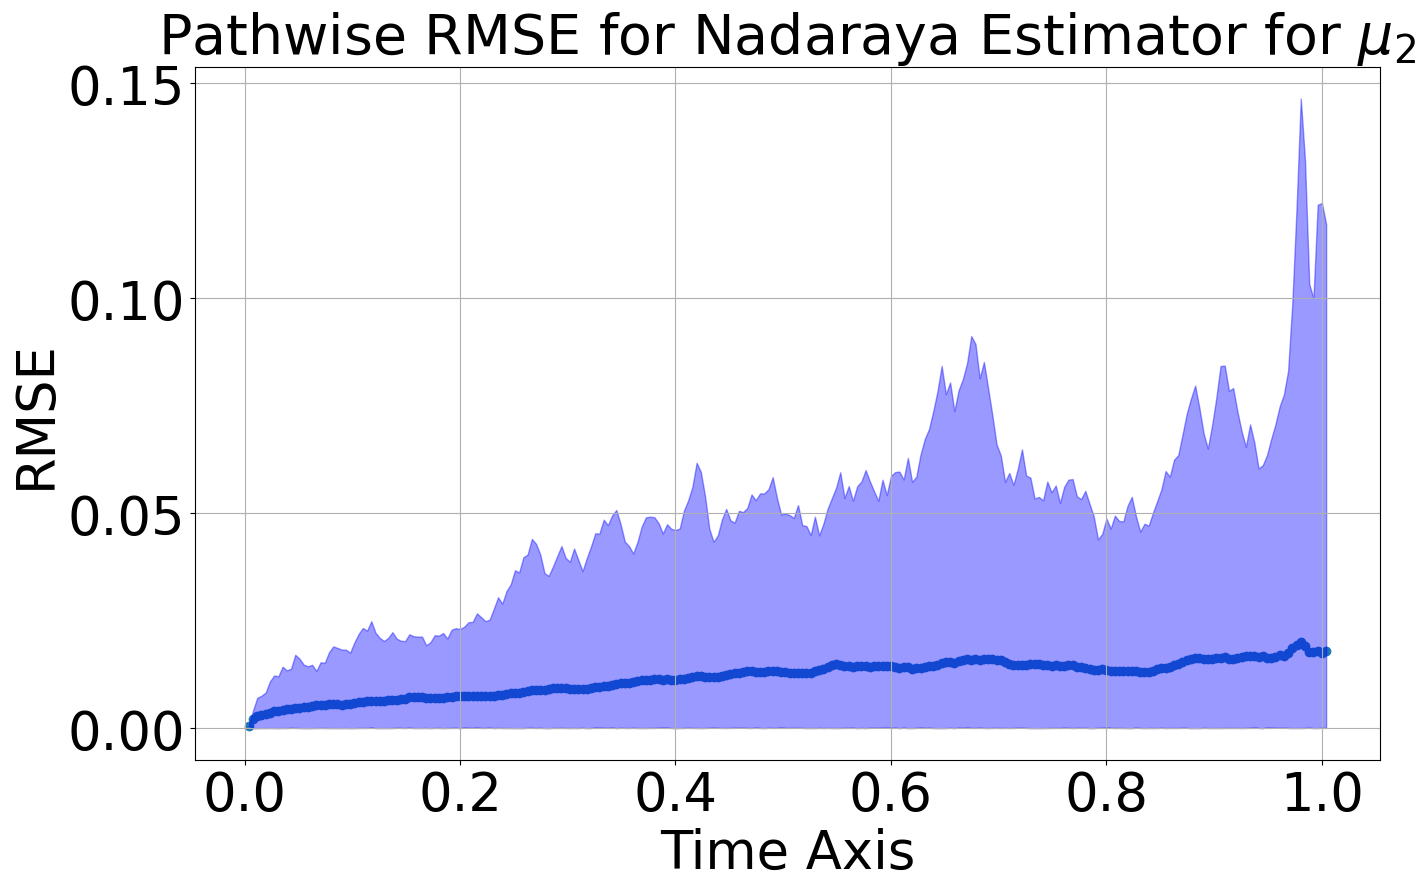

Final time cumulative MSE local-time error 0.01801021382829965 at bw 0.0013793

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/QuadSinHF2/IIDNadaraya_fQuadSinHF_DriftTrack_0013793bw_10240NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_global_states.npy
0.017751653939481214 0.0018211 0.01801021382829965


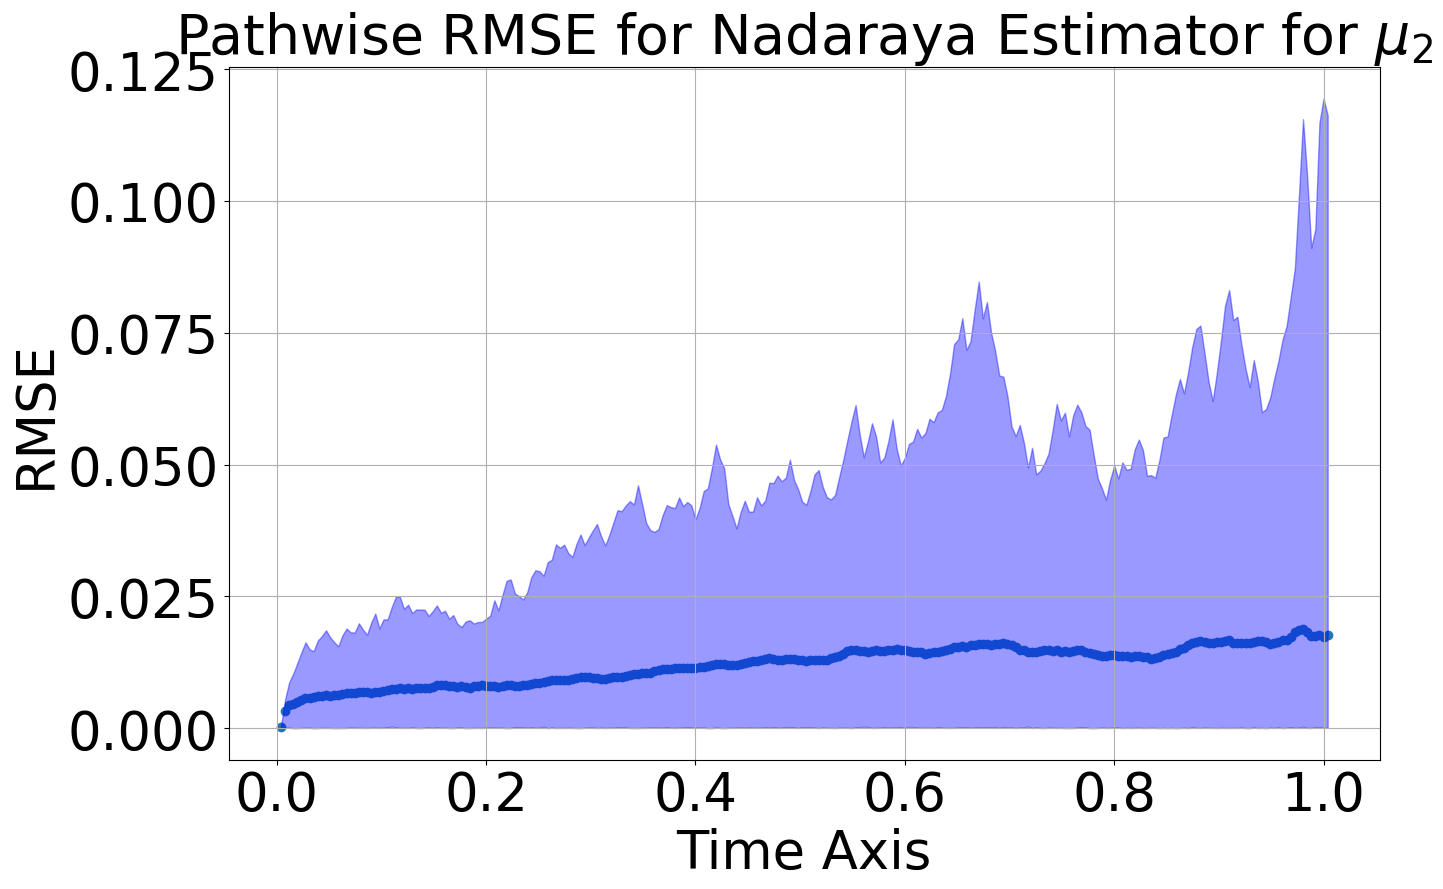

Final time cumulative MSE local-time error 0.017751653939481214 at bw 0.0018211

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/QuadSinHF2/IIDNadaraya_fQuadSinHF_DriftTrack_0018211bw_10240NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_global_states.npy
0.01817897007706222 0.0024046 0.017751653939481214
0.020546251949755023 0.0031749 0.017751653939481214
0.02543062025114687 0.0041919 0.017751653939481214
0.030605978839125723 0.0055348 0.017751653939481214
0.03549234425643507 0.0073079 0.017751653939481214
0.03899171030909682 0.009649 0.017751653939481214
0.041288721672929574 0.0127401 0.017751653939481214
0.04532108239794362 0.0168214 0.017751653939481214
0.05577341867734217 0.0222102 0.017751653939481214
0.07767072648358357 0.0293252 0.017751653939481214
0.11368440679700544 0.0387196 0.017751653939481214
0.16311129622792403 0.0511235 0.017751653939481214
0.21941359479707984 0.067501 0.017751653939481214
0.27

In [32]:
curr_mse = np.inf
toSave = True
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_mse)
        i += 1
        if i == 1: continue
        if total_local_errors[-1]  < curr_mse:
            curr_mse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(f"Pathwise RMSE for Nadaraya Estimator for {label}",fontsize=40)

            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)

            fig.canvas.draw()
            # Get the offset text (e.g., '1e-5')
            offset_text = ax.yaxis.get_offset_text().get_text()

            # Remove the offset text from the axis
            ax.yaxis.get_offset_text().set_visible(False)

            # Inject the scale into the y-axis label
            if offset_text:
                ax.set_ylabel(f'RMSE ({offset_text})', fontsize=38)
            else:
                ax.set_ylabel('RMSE', fontsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/{dirname}/IIDNadaraya_{ts_type}_DriftTrack_{round(bw, 6)}bw_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} at bw {bw}\n")
            print(file[1])